# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/processed/features_{GEO}.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1629, 35)


,tsne_0,tsne_1,tsne_2,kitchen,garden,microwave,backyard,iron,shampoo,wifi,...,dishwasher,silverware,bathtub,lockbox,crib,elevator,gym,oven,toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,-5.613824,-3.080757,2.447573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
133337,-2.376282,7.860886,2.428963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
150928,-5.809454,-2.778553,-1.081195,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
2706775,-10.103469,-1.812967,-2.710917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
8602878,1.280295,-2.094504,4.721372,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good


In [3]:
df.label.value_counts()

good     1320
mbad      118
mgood     105
bad        84
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [4]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [5]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1320
mgood    1320
mbad     1320
bad      1320
Name: label, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4224, 34)
Test shape: (1056, 34)


Use lazy predict to compare base models

In [7]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False).head(10)

100%|██████████| 29/29 [00:10<00:00,  2.67it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.93,0.93,None,0.93,0.43
LGBMClassifier,0.91,0.91,None,0.91,0.38
RandomForestClassifier,0.91,0.91,None,0.91,0.64
LabelPropagation,0.90,0.90,None,0.90,0.71
LabelSpreading,0.90,0.90,None,0.90,0.87
BaggingClassifier,0.90,0.90,None,0.90,0.22
KNeighborsClassifier,0.85,0.85,None,0.84,0.06
ExtraTreeClassifier,0.84,0.84,None,0.84,0.02
DecisionTreeClassifier,0.82,0.83,None,0.82,0.04


Tune hyperparamters of SVC (Support Vector Classifier)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9185606060606061


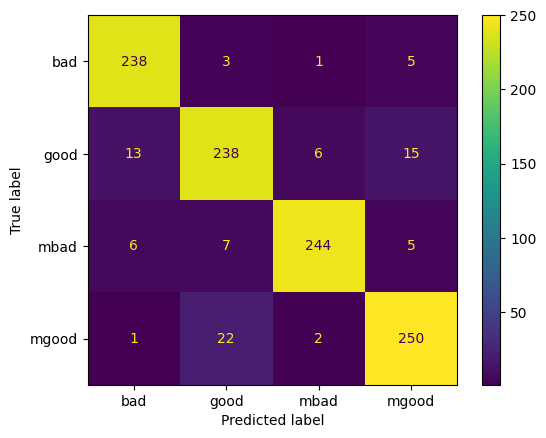

In [8]:
# load ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
}

clf = GridSearchCV(ExtraTreesClassifier(), params, cv=5, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

